In [ ]:
import torch
import torch.nn as nn
import math

## 1. Input of **Input Embedding**



image.png




## 2. Output of **Input Embedding**

- `seq_len` = 4

- `d_model` = 6



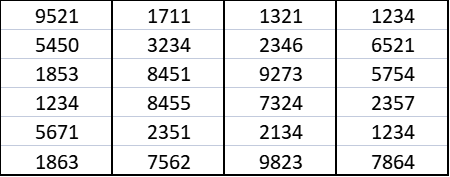



## 3. Positional Encoding Matrix

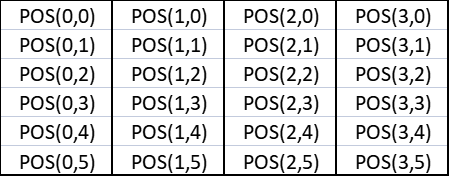

- Compute this out using below formula

$$
PE(\text{position}, 2i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$

$$
PE(\text{position}, 2i+1) = \cos\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$



We can rewrite these as

$$
PE(\text{position}, i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{i}{d_{model}}} \bigg) \text{ when i is even}
$$

$$
PE(\text{position}, i) = \cos\bigg( \frac{ \text{position} }{10000^\frac{i-1}{d_{model}}} \bigg) \text{ when i is odd}
$$

### Diving Deep

In [ ]:
# We have an input of (4,6)
seq_len = 4
d_model = 6

In [ ]:
even_i = torch.arange(0, d_model, 2).float()
even_i

tensor([0., 2., 4.])

In [ ]:
even_denominator = torch.pow(10000, even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [ ]:
odd_i = torch.arange(1, d_model, 2).float()
odd_i

tensor([1., 3., 5.])

In [ ]:
odd_denominator = torch.pow(10000, (odd_i - 1)/d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

`even_denominator` and `odd_denominator` are the same!

So we can just do one of these actions and call the resulting variable `denominator`

In [ ]:
denominator = even_denominator

In [ ]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length, 1)

In [ ]:
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [ ]:
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)

In [ ]:
even_PE

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [ ]:
even_PE.shape

torch.Size([10, 3])

In [ ]:
odd_PE

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [ ]:
odd_PE.shape

torch.Size([10, 3])

In [ ]:
stacked = torch.stack([even_PE, odd_PE], dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [ ]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

Wrap in a Class

In [ ]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)